<div align="center">

# <span style="color: #3498db;">Genetic & MiniMax</span>

**<span style="color:rgb(247, 169, 0);">Artin Tavasoli</span> - <span style="color:rgb(143, 95, 195);">810102543</span>**

</div>


## 🧬 Part 1: Approximating Fourier Coefficients Using Genetic Algorithm

**Objective:**  
Estimate the Fourier series coefficients of an unknown function using a genetic algorithm.

---



In [2]:
import matplotlib.pyplot as plt

# <span style="color: #3498db;">Genetic Algorithm</span>

In [3]:
import random
import itertools
import numpy as np
import sys
sys.setrecursionlimit(3000)


In [4]:
# algorithm parameters
numCoeffs = 41
populationSize = 100
generations = 500
mutationRate = 0.1
functionRange = (-np.pi, np.pi)
sampleCount = 100
coeff_range = (-2, 2)
crossover_rate =  0.8
tournament_var = 5
crossover_type = 0
fitness_type = 0 
selection_type = 0
number_of_points_crossover = 3
random.seed(543)

In [5]:
# These functions are given as samples to use in the algorithm
def getTargetFunction(functionName="sin_cos"):
    def sinCosFunction(t):
        """Target function: sin(2πt) + 0.5*cos(4πt)."""
        return np.sin(2 * np.pi * t) + 0.5 * np.cos(4 * np.pi * t)

    def linearFunction(t):
        """Simple linear function: y = 2t + 1."""
        return 2 * t + 1

    def quadraticFunction(t):
        """Quadratic function: y = 4t^2 - 4t + 2."""
        return 4 * (t**2) - 4 * t + 2

    def cubicFunction(t):
        """Cubic function: y = 8t^3 - 12t^2 + 6t."""
        return 8 * (t**3) - 12 * (t**2) + 6 * t

    def gaussianFunction(t):
        """Gaussian function centered at t=0.5."""
        mu = 0.5
        sigma = 0.1  # Adjust sigma to control the width of the peak
        return np.exp(-((t - mu) ** 2) / (2 * sigma**2))

    def squareWaveFunction(t):
        """Approximation of a square wave. Smoothed for better Fourier approximation."""
        return 0.5 * (np.sign(np.sin(2 * np.pi * t)) + 1)

    def sawtoothFunction(t):
        """Sawtooth wave, normalized to [0, 1]."""
        return (t * 5) % 1

    def complexFourierFunction(t):
        return (
            np.sin(2 * np.pi * t)
            + 0.3 * np.cos(4 * np.pi * t)
            + 0.2 * np.sin(6 * np.pi * t)
            + 0.1 * np.cos(8 * np.pi * t)
        )

    def polynomialFunction(t):
        return 10 * (t**5) - 20 * (t**4) + 15 * (t**3) - 4 * (t**2) + t + 0.5

    functionOptions = {
        "sin_cos": sinCosFunction,
        "linear": linearFunction,
        "quadratic": quadraticFunction,
        "cubic": cubicFunction,
        "gaussian": gaussianFunction,
        "square_wave": squareWaveFunction,
        "sawtooth": sawtoothFunction,
        "complex_fourier": complexFourierFunction,
        "polynomial": polynomialFunction,
    }

    selectedFunction = functionOptions.get(functionName.lower())
    if selectedFunction:
        return selectedFunction

In [6]:
def gen_tsamples_and_fsamples(function_name):
    tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
    fSamples = getTargetFunction(function_name)(tSamples)
    return tSamples, fSamples

In [7]:
def create_first_gen_chromosome(fSamples):
    coeffs = np.random.uniform(coeff_range[0], coeff_range[1], size=numCoeffs)
    first_coeff = coeffs[0]
    cos_coeffs = coeffs[1:(numCoeffs + 1) // 2]
    sin_coeffs = coeffs[(numCoeffs + 1) // 2:]
    # valid_boarder = check_fboarder(first_coeff, cos_coeffs, sin_coeffs, maxf, minf, is_f_periodic)
    # if not valid_boarder:
    #     return create_first_gen_chromosome(fSamples, is_f_periodic)
    return [first_coeff, cos_coeffs, sin_coeffs]

In [8]:
def create_first_gen_chromosomes(fSamples):
    chromosomes = []
    for _ in range(populationSize):
        chromosomes.append(create_first_gen_chromosome(fSamples))
    return chromosomes

In [9]:
def calculate_chromosome_fvals(chromosome, tSamples):
    number_of_terms = (numCoeffs - 1) // 2
    index_arr = np.arange(1, number_of_terms + 1)
    cos_terms = np.cos(np.outer(tSamples, index_arr))
    sin_terms = np.sin(np.outer(tSamples, index_arr))
    a0 = chromosome[0] / 2
    cosine_coeffs = np.array(chromosome[1])
    sine_coeffs = np.array(chromosome[2])
    f_vals = a0 + cos_terms @ cosine_coeffs + sin_terms @ sine_coeffs
    return f_vals

In [10]:
def calculate_chromosomes_fvals(chromosomes, tSamples):
    f_values_for_chromosomes = []
    for chromosome in chromosomes:
        f_vals = calculate_chromosome_fvals(chromosome, tSamples)
        f_values_for_chromosomes.append(f_vals.tolist())
    return f_values_for_chromosomes

In [11]:
def rank_chromosomes_by_rmse(chromosomes, tSamples, fSamples):
    f_values = np.array(calculate_chromosomes_fvals(chromosomes, tSamples))

    fitness_vals = np.sqrt(np.mean((f_values - fSamples) ** 2, axis=1))

    sorted_indexes = np.argsort(fitness_vals)

    sorted_chromosomes = [chromosomes[i] for i in sorted_indexes]
    
    fitness_vals = fitness_vals[sorted_indexes]
    
    return fitness_vals, sorted_chromosomes


In [12]:
def rank_chromosomes_by_mae(chromosomes, tSamples, fSamples):
    f_values = np.array(calculate_chromosomes_fvals(chromosomes, tSamples))

    fitness_vals = np.mean(np.abs(f_values - fSamples), axis=1)

    sorted_indexes = np.argsort(fitness_vals)

    sorted_chromosomes = [chromosomes[i] for i in sorted_indexes]
    
    fitness_vals = fitness_vals[sorted_indexes]
    
    return fitness_vals, sorted_chromosomes

In [13]:
def rank_chromosomes_by_cnt_close_points(chromosomes, tSamples, fSamples, error_interval):
    f_values = np.array(calculate_chromosomes_fvals(chromosomes, tSamples))

    close_points = np.abs(f_values - fSamples) <= error_interval

    fitness_vals = np.sum(close_points, axis=1)

    sorted_indexes = np.argsort(-fitness_vals)

    sorted_chromosomes = [chromosomes[i] for i in sorted_indexes]
    
    fitness_vals = fitness_vals[sorted_indexes]

    return fitness_vals, sorted_chromosomes


In [14]:
def split_replace(arr1, arr2):
    points = np.sort(np.random.choice(np.arange(1, len(arr1)), size=number_of_points_crossover, replace=False))
    points = np.hstack(([0], points, [len(arr1)]))
    child1 = []
    child2 = []
    for i in range(len(points) - 1):
        start, end = points[i], points[i + 1]
        if i % 2 == 0:
            child1.append(arr1[start:end])
            child2.append(arr2[start:end])
        else:
            child1.append(arr2[start:end])
            child2.append(arr1[start:end])
    return np.hstack(child1), np.hstack(child2)

In [15]:
def cross_over0(chromosome1, chromosome2):
    if np.random.rand() < crossover_rate:
        return [chromosome1, chromosome2]
     
    chrom1_a0, chrom1_cos, chrom1_sin = chromosome1
    chrom2_a0, chrom2_cos, chrom2_sin = chromosome2
    if np.random.rand() < 0.5:
        a0_child1 = chrom1_a0
        a0_child2 = chrom2_a0
    else:
        a0_child1 = chrom2_a0
        a0_child2 = chrom1_a0
    cos_child1, cos_child2 = split_replace(chrom1_cos, chrom2_cos)
    sin_child1, sin_child2 = split_replace(chrom1_sin, chrom2_sin)
    return [[a0_child1, cos_child1, sin_child1], [a0_child2, cos_child2, sin_child2]]

In [16]:
def cross_over1(chromosome1, chromosome2):
    if np.random.rand() < crossover_rate:
        return [chromosome1, chromosome2]
    
    chrom1_a0, chrom1_cos, chrom1_sin = chromosome1
    chrom2_a0, chrom2_cos, chrom2_sin = chromosome2
    if np.random.rand() < 0.5:
        a0_child1 = chrom1_a0
        a0_child2 = chrom2_a0
    else:
        a0_child1 = chrom2_a0
        a0_child2 = chrom1_a0

    rand_point = random.randint(1, len(chrom1_cos) - 1)

    cos_child1 = np.hstack([chrom1_cos[:rand_point], chrom2_cos[rand_point:]])
    cos_child2 = np.hstack([chrom2_cos[:rand_point], chrom1_cos[rand_point:]])

    sin_child1 = np.hstack([chrom1_sin[:rand_point], chrom2_sin[rand_point:]])
    sin_child2 = np.hstack([chrom2_sin[:rand_point], chrom1_sin[rand_point:]])
    return [[a0_child1, cos_child1, sin_child1], [a0_child2, cos_child2, sin_child2]]

In [17]:
def cross_over2(chromosome1, chromosome2):
    if np.random.rand() < crossover_rate:
        return [chromosome1, chromosome2]
    
    chrom1_a0, chrom1_cos, chrom1_sin = chromosome1
    chrom2_a0, chrom2_cos, chrom2_sin = chromosome2
    if np.random.rand() < 0.5:
        a0_child1 = chrom1_a0
        a0_child2 = chrom2_a0
    else:
        a0_child1 = chrom2_a0
        a0_child2 = chrom1_a0
    
    cos_mask = np.random.choice([0, 1], size=len(chrom1_cos))
    sin_mask = np.random.choice([0, 1], size=len(chrom1_sin))
    
    new_cos_child1 = np.where(cos_mask, chrom1_cos, chrom2_cos)
    new_sin_child1 = np.where(sin_mask, chrom1_sin, chrom2_sin)
    
    new_cos_child2 = np.where(cos_mask, chrom2_cos, chrom1_cos)
    new_sin_child2 = np.where(sin_mask, chrom2_sin, chrom1_sin)
    
    return [[a0_child1, new_cos_child1, new_sin_child1], [a0_child2, new_cos_child2, new_sin_child2]]

In [18]:
def mutation(chromosome, mutation_val):
    a0, cos_coeffs, sin_coeffs = chromosome
    if np.random.rand() < mutationRate:
        a0 += np.random.normal(0, mutation_val)
    n = len(cos_coeffs)
    cos_coeffs = cos_coeffs + np.random.normal(0, mutation_val, size=n) * (np.random.rand(n) < mutationRate)
    sin_coeffs = sin_coeffs + np.random.normal(0, mutation_val, size=n) * (np.random.rand(n) < mutationRate)
    return [a0, cos_coeffs, sin_coeffs]

In [19]:
def tournament_selection(chromosomes, fitness_vals):
    indixes = np.random.choice(len(chromosomes), size=tournament_var, replace=False)
    best_index = indixes[np.argmin(fitness_vals[indixes])]
    return chromosomes[best_index]


In [20]:
def rank_based_roulette_wheel(chromosomes):
    ranks = np.arange(1, len(chromosomes) + 1)
    inverse_ranks = 1 / ranks
    probabilities = inverse_ranks / np.sum(inverse_ranks)
    selected_index = np.random.choice(len(chromosomes), p=probabilities)
    return chromosomes[selected_index]

In [21]:
def ga_cycle(chromosomes, best_chroms_cnt, cross_over_cnt, tSamples, fSamples):
    next_generation = []
    if fitness_type == 0:
        fitness_vals, chromosomes = rank_chromosomes_by_rmse(chromosomes, tSamples, fSamples)
    elif fitness_type == 1:
        fitness_vals, chromosomes = rank_chromosomes_by_mae(chromosomes, tSamples, fSamples)
    else:
        fitness_vals, chromosomes = rank_chromosomes_by_cnt_close_points(chromosomes, tSamples, fSamples, 0.1)
        
    for _ in range(cross_over_cnt):
        if selection_type == 0:
            parent1 = tournament_selection(chromosomes, fitness_vals)
            parent2 = tournament_selection(chromosomes, fitness_vals)
        else:
            parent1 = rank_based_roulette_wheel(chromosomes)
            parent2 = rank_based_roulette_wheel(chromosomes)
        if crossover_type == 0:
            child1, child2 = cross_over0(parent1, parent2)
        elif crossover_type == 1:
            child1, child2 = cross_over1(parent1, parent2)
        else:
            child1, child2 = cross_over2(parent1, parent2)
        next_generation.append(child1)
        next_generation.append(child2)
    
    for _ in range(best_chroms_cnt):
        if selection_type == 0:
            best = tournament_selection(chromosomes, fitness_vals)
        else:
            best = rank_based_roulette_wheel(chromosomes)
        next_generation.append(best)

    for i in range(len(next_generation)):
        next_generation[i] = mutation(next_generation[i], np.max(fSamples) / 10)

    return next_generation

In [22]:
def calc_final_f_vals(tSamples, fSamples):
    chromosomes = create_first_gen_chromosomes(fSamples)
    best_chroms_cnt = 8
    cross_over_cnt = populationSize - best_chroms_cnt

    for _ in range(generations):
        chromosomes = ga_cycle(chromosomes, best_chroms_cnt, cross_over_cnt, tSamples, fSamples)
    f_vals = calculate_chromosome_fvals(chromosomes[0], tSamples)
    return f_vals


CROSS_OVER_TYPES

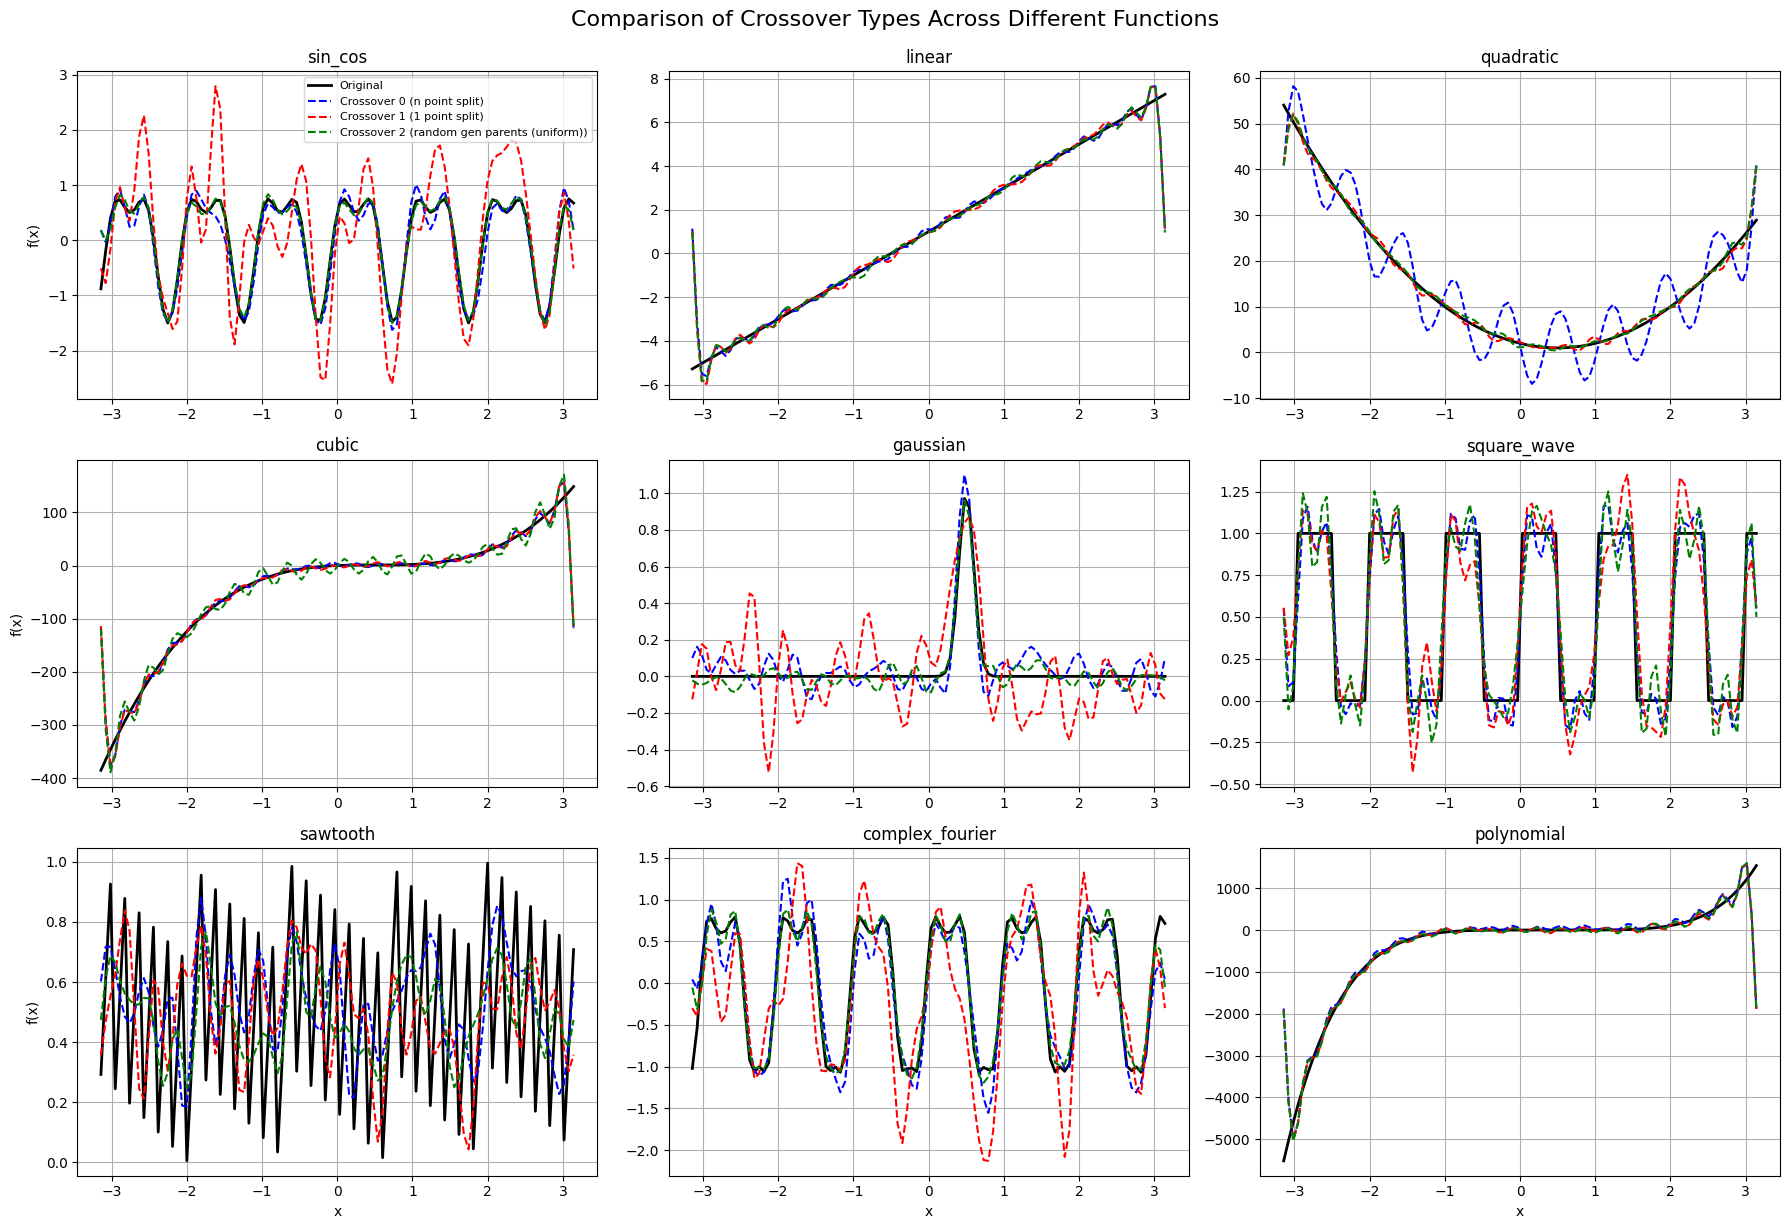

In [ ]:
function_name = ["sin_cos", "linear", "quadratic", "cubic", "gaussian", "square_wave", "sawtooth", "complex_fourier", "polynomial"]
populationSize = 100
generations = 200
mutationRate = 0.01
coeff_range = (-2, 2)
crossover_rate =  0.8
fitness_type = 0 
selection_type = 0

plt.figure(figsize=(18, 12))

for i, name in enumerate(function_name):
    tSamples, fSamples = gen_tsamples_and_fsamples(name)

    crossover_type = 0
    f_vals = calc_final_f_vals(tSamples, fSamples)

    crossover_type = 1
    f_vals2 = calc_final_f_vals(tSamples, fSamples)

    crossover_type = 2
    f_vals3 = calc_final_f_vals(tSamples, fSamples)

    plt.subplot(3, 3, i + 1)
    plt.plot(tSamples, fSamples, label='Original', color='black', linewidth=2)
    plt.plot(tSamples, f_vals, label='Crossover 0 (n point split)', linestyle='--', color='blue')
    plt.plot(tSamples, f_vals2, label='Crossover 1 (1 point split)', linestyle='--', color='red')
    plt.plot(tSamples, f_vals3, label='Crossover 2 (random gen parents (uniform))', linestyle='--', color='green')
    
    plt.title(name)
    plt.grid(True)
    if i == 0:
        plt.legend(fontsize=8)
    if i >= 6:
        plt.xlabel('x')
    if i % 3 == 0:
        plt.ylabel('f(x)')

plt.tight_layout()
plt.suptitle('Comparison of Crossover Types Across Different Functions', fontsize=16, y=1.02)
plt.show()

Fitness Types

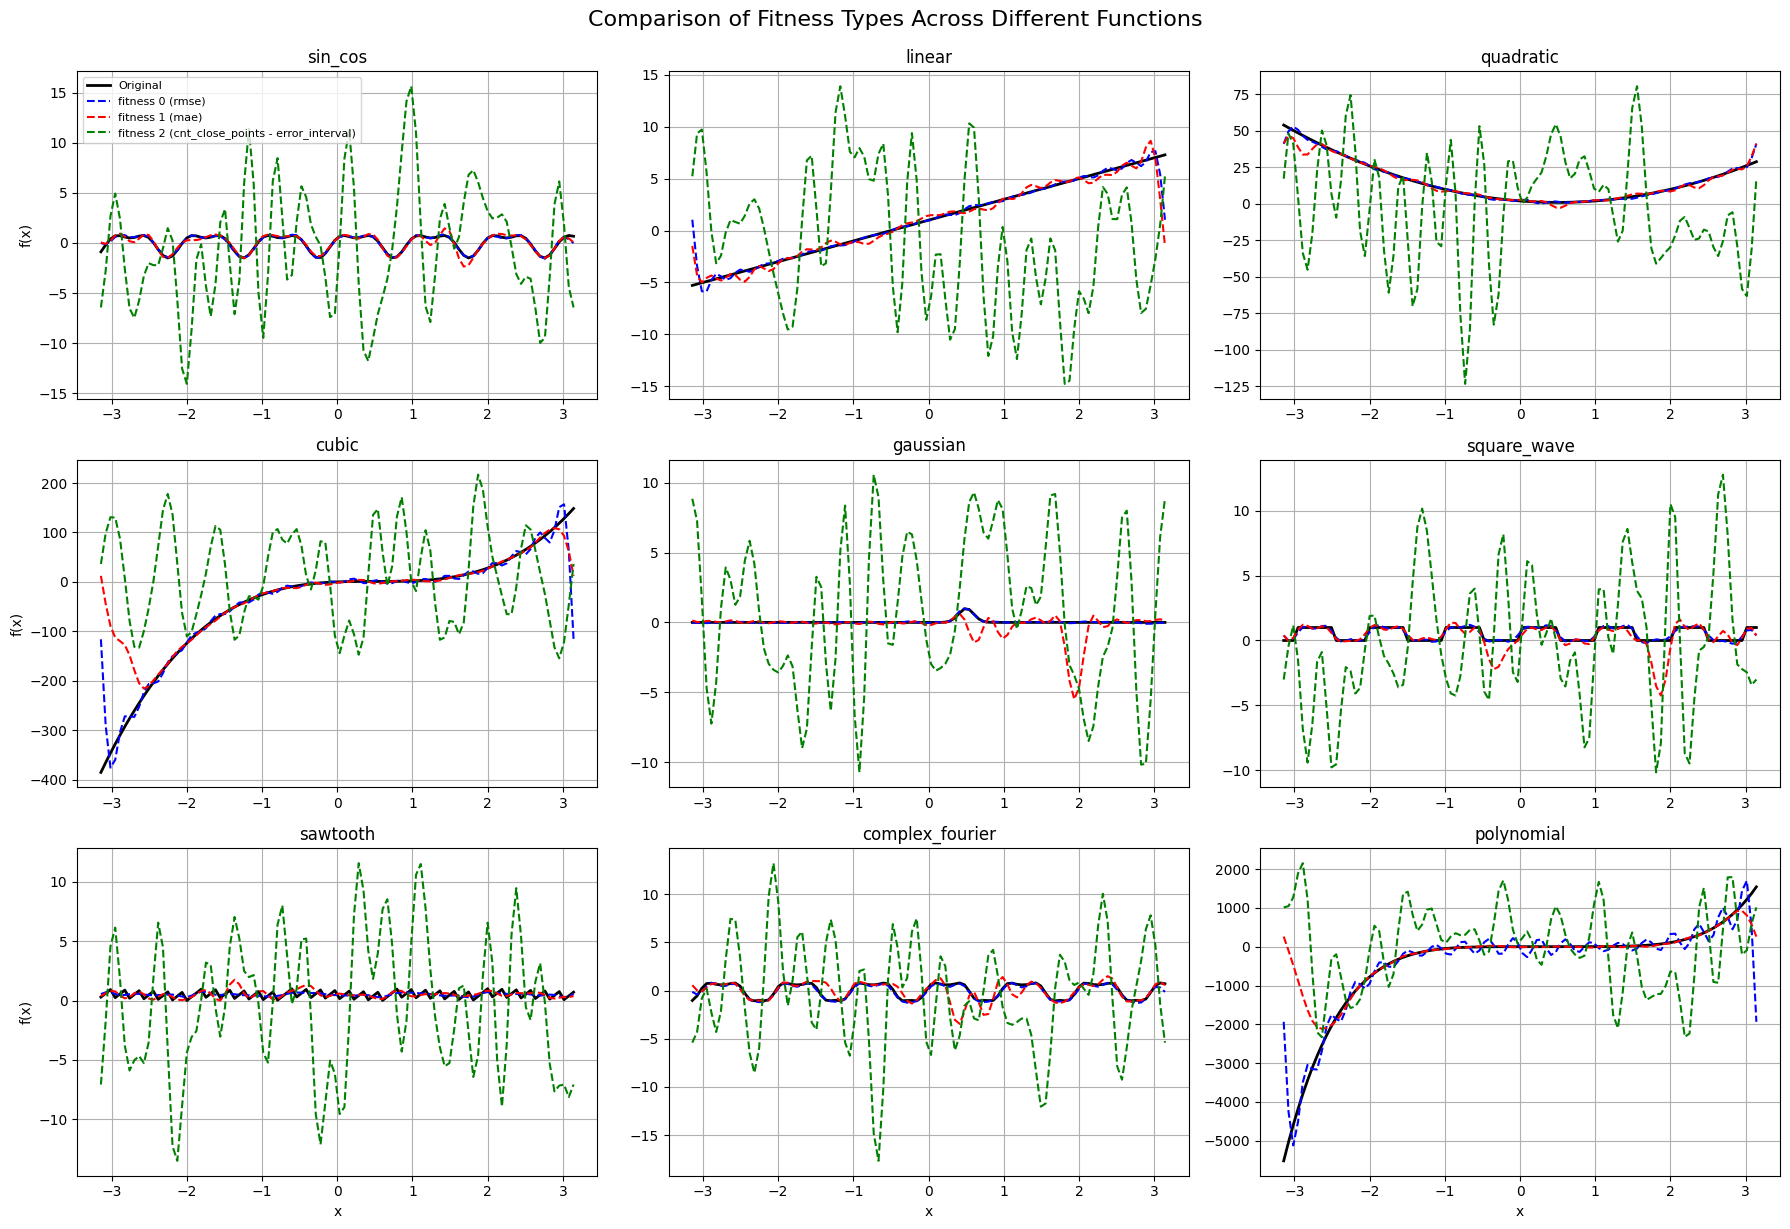

In [24]:
function_name = ["sin_cos", "linear", "quadratic", "cubic", "gaussian", "square_wave", "sawtooth", "complex_fourier", "polynomial"]
populationSize = 100
generations = 200
mutationRate = 0.01
coeff_range = (-2, 2)
crossover_rate =  0.8
fitness_type = 0 
crossover_type = 2
selection_type = 0

plt.figure(figsize=(18, 12))

for i, name in enumerate(function_name):
    tSamples, fSamples = gen_tsamples_and_fsamples(name)

    fitness_type = 0
    f_vals = calc_final_f_vals(tSamples, fSamples)

    fitness_type = 1
    f_vals2 = calc_final_f_vals(tSamples, fSamples)

    fitness_type = 2
    f_vals3 = calc_final_f_vals(tSamples, fSamples)

    plt.subplot(3, 3, i + 1)
    plt.plot(tSamples, fSamples, label='Original', color='black', linewidth=2)
    plt.plot(tSamples, f_vals, label='fitness 0 (rmse)', linestyle='--', color='blue')
    plt.plot(tSamples, f_vals2, label='fitness 1 (mae)', linestyle='--', color='red')
    plt.plot(tSamples, f_vals3, label='fitness 2 (cnt_close_points - error_interval)', linestyle='--', color='green')
    
    plt.title(name)
    plt.grid(True)
    if i == 0:
        plt.legend(fontsize=8)
    if i >= 6:
        plt.xlabel('x')
    if i % 3 == 0:
        plt.ylabel('f(x)')

plt.tight_layout()
plt.suptitle('Comparison of Fitness Types Across Different Functions', fontsize=16, y=1.02)
plt.show()

Selection Type

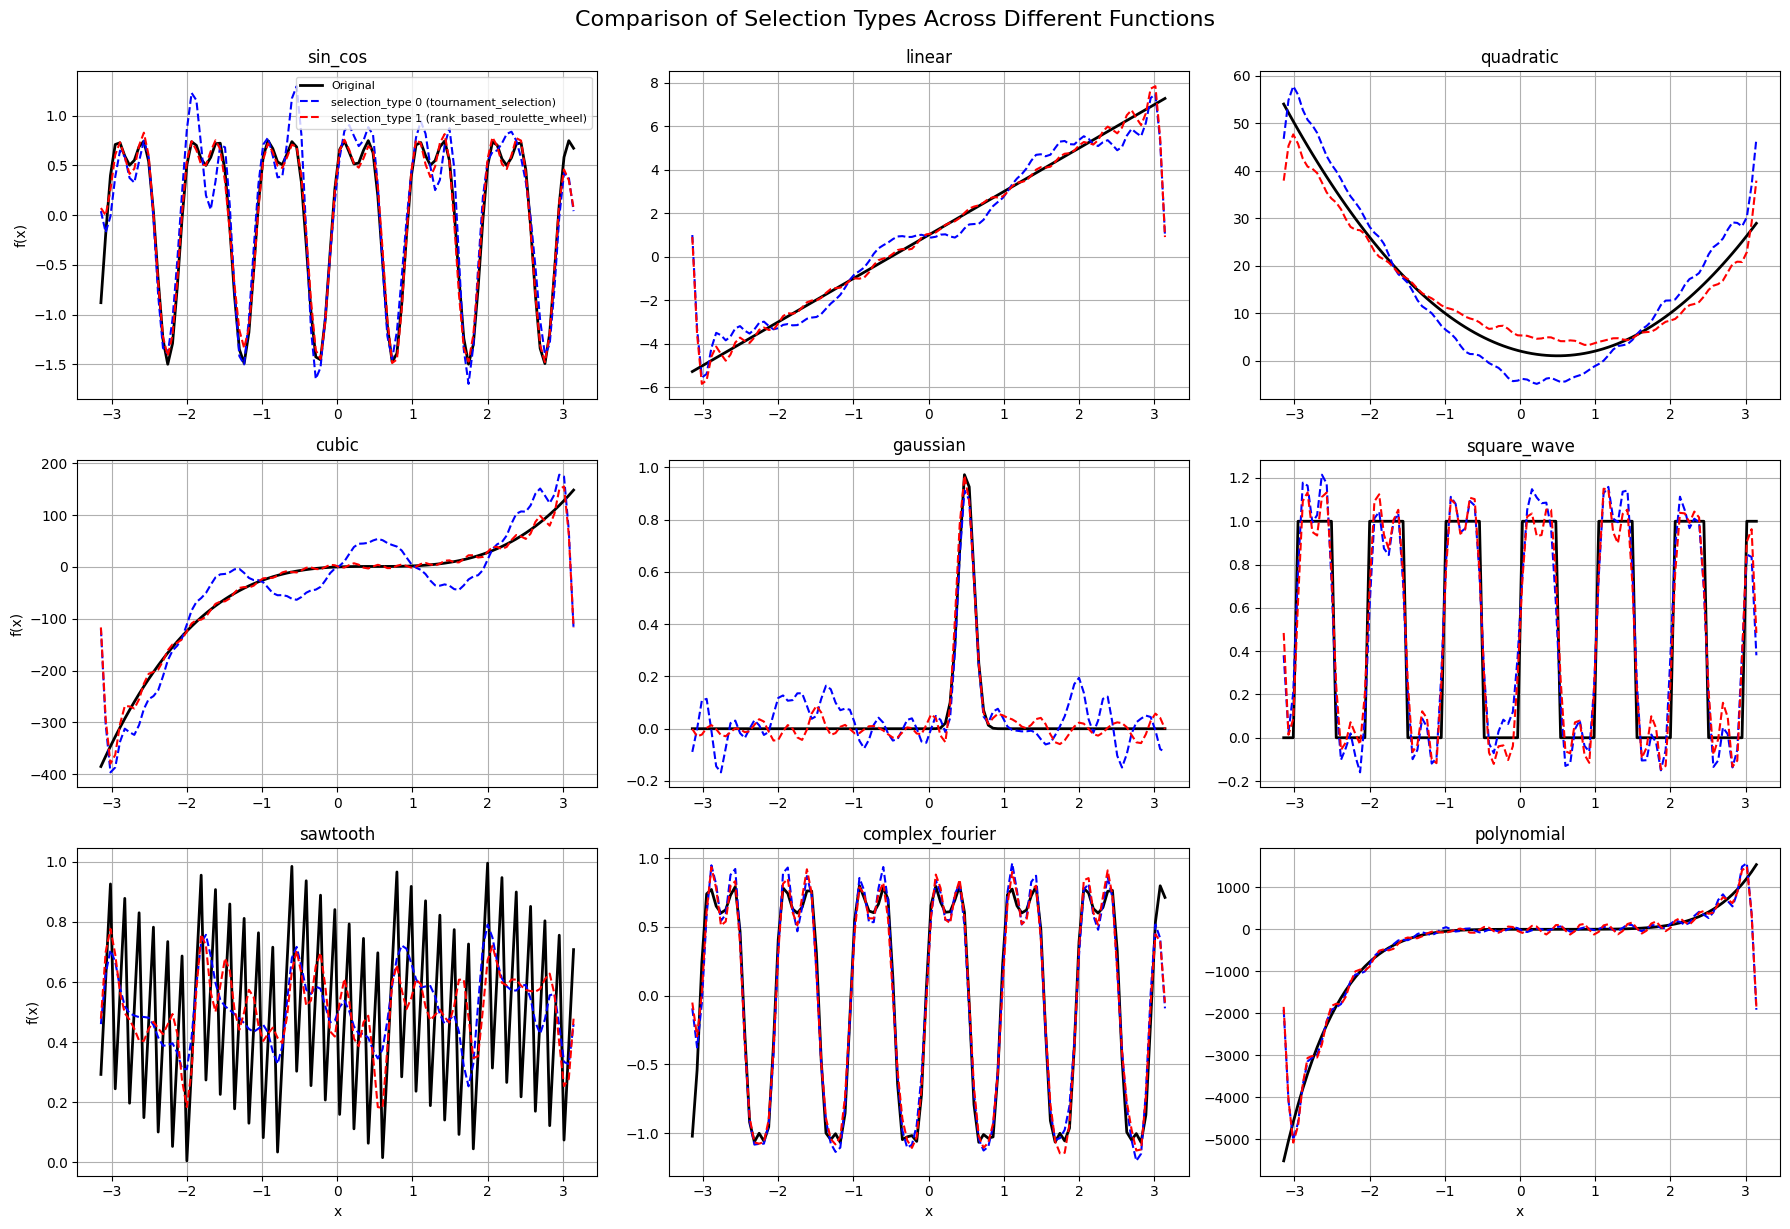

In [25]:
function_name = ["sin_cos", "linear", "quadratic", "cubic", "gaussian", "square_wave", "sawtooth", "complex_fourier", "polynomial"]
populationSize = 100
generations = 200
mutationRate = 0.01
coeff_range = (-2, 2)
crossover_rate =  0.8
fitness_type = 0 
crossover_type = 2

plt.figure(figsize=(18, 12))

for i, name in enumerate(function_name):
    tSamples, fSamples = gen_tsamples_and_fsamples(name)

    selection_type = 0
    f_vals = calc_final_f_vals(tSamples, fSamples)

    selection_type = 1
    f_vals2 = calc_final_f_vals(tSamples, fSamples)

    plt.subplot(3, 3, i + 1)
    plt.plot(tSamples, fSamples, label='Original', color='black', linewidth=2)
    plt.plot(tSamples, f_vals, label='selection_type 0 (tournament_selection)', linestyle='--', color='blue')
    plt.plot(tSamples, f_vals2, label='selection_type 1 (rank_based_roulette_wheel)', linestyle='--', color='red')
    
    plt.title(name)
    plt.grid(True)
    if i == 0:
        plt.legend(fontsize=8)
    if i >= 6:
        plt.xlabel('x')
    if i % 3 == 0:
        plt.ylabel('f(x)')

plt.tight_layout()
plt.suptitle('Comparison of Selection Types Across Different Functions', fontsize=16, y=1.02)
plt.show()

Population size

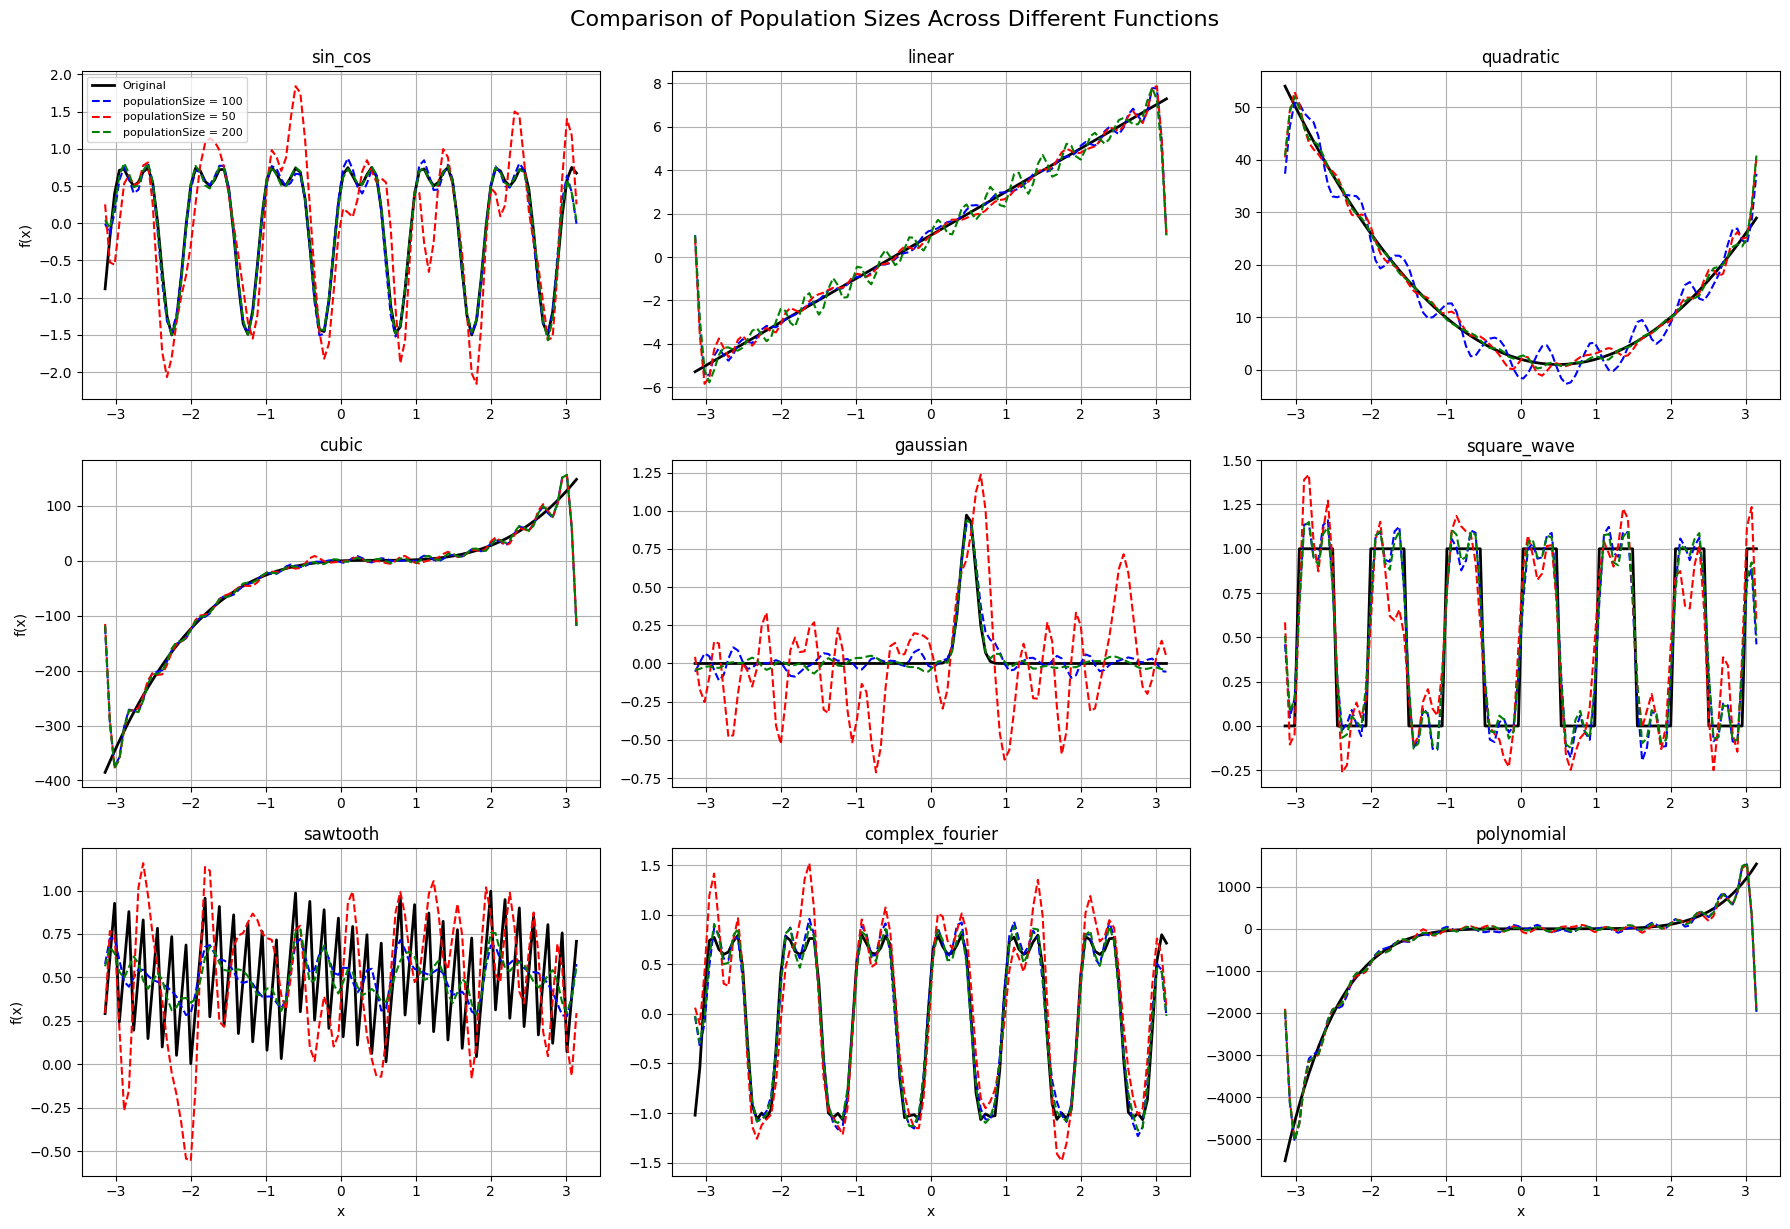

In [26]:
function_name = ["sin_cos", "linear", "quadratic", "cubic", "gaussian", "square_wave", "sawtooth", "complex_fourier", "polynomial"]
populationSize = 100
generations = 200
mutationRate = 0.01
coeff_range = (-2, 2)
crossover_rate =  0.8
fitness_type = 0 
crossover_type = 2
selection_type = 0

plt.figure(figsize=(18, 12))

for i, name in enumerate(function_name):
    tSamples, fSamples = gen_tsamples_and_fsamples(name)

    populationSize = 100
    f_vals = calc_final_f_vals(tSamples, fSamples)

    populationSize = 50
    f_vals2 = calc_final_f_vals(tSamples, fSamples)

    populationSize = 200
    f_vals3 = calc_final_f_vals(tSamples, fSamples)

    plt.subplot(3, 3, i + 1)
    plt.plot(tSamples, fSamples, label='Original', color='black', linewidth=2)
    plt.plot(tSamples, f_vals, label='populationSize = 100', linestyle='--', color='blue')
    plt.plot(tSamples, f_vals2, label='populationSize = 50', linestyle='--', color='red')
    plt.plot(tSamples, f_vals3, label='populationSize = 200', linestyle='--', color='green')
    
    plt.title(name)
    plt.grid(True)
    if i == 0:
        plt.legend(fontsize=8)
    if i >= 6:
        plt.xlabel('x')
    if i % 3 == 0:
        plt.ylabel('f(x)')

plt.tight_layout()
plt.suptitle('Comparison of Population Sizes Across Different Functions', fontsize=16, y=1.02)
plt.show()

Generations size

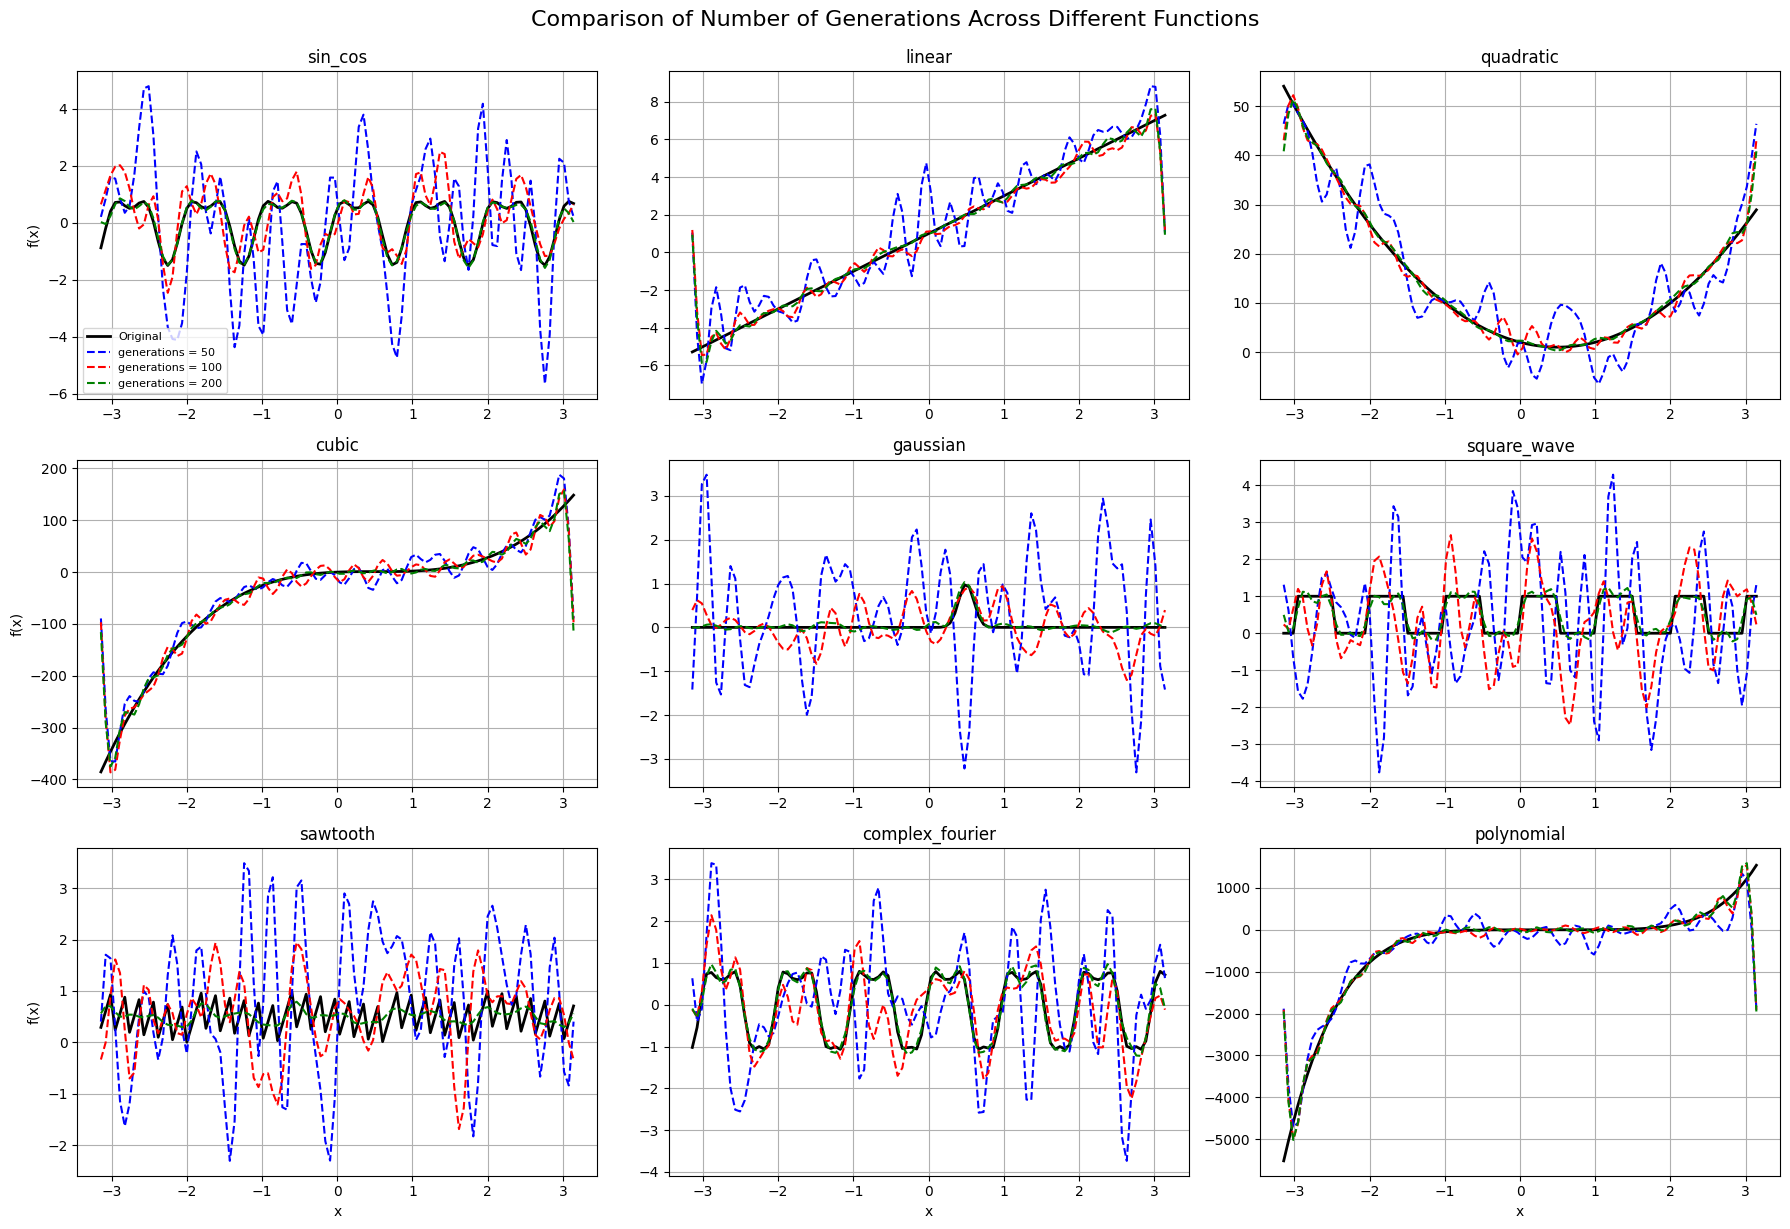

In [27]:
function_name = ["sin_cos", "linear", "quadratic", "cubic", "gaussian", "square_wave", "sawtooth", "complex_fourier", "polynomial"]
populationSize = 100
generations = 200
mutationRate = 0.01
coeff_range = (-2, 2)
crossover_rate =  0.8
fitness_type = 0 
crossover_type = 2
selection_type = 0

plt.figure(figsize=(18, 12))

for i, name in enumerate(function_name):
    tSamples, fSamples = gen_tsamples_and_fsamples(name)

    generations = 50
    f_vals = calc_final_f_vals(tSamples, fSamples)

    generations = 100
    f_vals2 = calc_final_f_vals(tSamples, fSamples)

    generations = 200
    f_vals3 = calc_final_f_vals(tSamples, fSamples)

    plt.subplot(3, 3, i + 1)
    plt.plot(tSamples, fSamples, label='Original', color='black', linewidth=2)
    plt.plot(tSamples, f_vals, label='generations = 50', linestyle='--', color='blue')
    plt.plot(tSamples, f_vals2, label='generations = 100', linestyle='--', color='red')
    plt.plot(tSamples, f_vals3, label='generations = 200', linestyle='--', color='green')
    
    plt.title(name)
    plt.grid(True)
    if i == 0:
        plt.legend(fontsize=8)
    if i >= 6:
        plt.xlabel('x')
    if i % 3 == 0:
        plt.ylabel('f(x)')

plt.tight_layout()
plt.suptitle('Comparison of Number of Generations Across Different Functions', fontsize=16, y=1.02)
plt.show()